<a href="https://colab.research.google.com/github/comparativechrono/computational_biology_notebooks/blob/main/circadian_cobweb_worked_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Course:` **Mathematical & Computational Biology**  
`Module:` Cobweb analysis of circadian rhythms  
`Author:` Tim Hearn  
`License:` CC-BY-4.0

# Cobweb (Entrainment‑Map) Analysis of Circadian Rhythms
**Visualising entrainment, re‑entrainment and light‑therapy design**

## 1 Overview  
Cobwebbing is already a mainstream tool in chronobiology, where it goes by the name “entrainment map.” This notebook shows how the **cobweb (stair‑step) diagram**— you are familiar with from discrete dynamical systems—becomes an *entrainment map* for circadian clocks.  
You will learn to

1. derive a one‑day return map $x_{n+1} = F(x_n)$
from an intrinsic clock period and a phase‑response curve (PRC);
2. draw cobwebs to predict phase of entrainment, stability and recovery time;
3. model jet‑lag, bright‑light therapy and photoperiod changes by reshaping that map.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.grid'] = True


### 2 From an oscillator to a one‑day map

A simple but widely used approximation writes the daily phase shift as the sum of

- the clock’s intrinsic drift $(\tau_{\text{int}} - 24)$, and  
- the phase shift $\Delta(x)$ induced by the day’s light exposure, read off a phase-response curve.

Assuming lights-on at Zeitgeber Time 0 (ZT 0), let

$$
x_n = \text{hours since ZT 0 when the oscillator crosses its reference phase on day } n.
$$

Then

$$
x_{n+1}
= \bigl[\,x_n + (\tau_{\text{int}} - 24) + \Delta(x_n)\,\bigr] \pmod{24}.
$$

That is our map $F(x)$.


In [2]:
# --- Core functions ----------------------------------------------------------
def sinusoidal_prc(phi, A=1.5, shift=0):
    """Sinusoidal phase‑response curve in hours (positive = advance)."""
    return A * np.sin(2*np.pi*(phi - shift)/24)

def make_map(tau_int=24.2, prc_fun=sinusoidal_prc):
    """Return entrainment map F(x) for given intrinsic period and PRC."""
    drift = tau_int - 24
    return lambda x: (x + drift + prc_fun(x)) % 24


In [3]:
def cobweb(F, x0, days=40, ax=None, title=None, color='C1'):
    """Plot cobweb for map F beginning at phase x0 (hours)."""
    if ax is None:
        fig, ax = plt.subplots()
    xs = np.linspace(0, 24, 400)
    ax.plot(xs, F(xs), 'k', label='$y=F(x)$')
    ax.plot(xs, xs, 'k--', label='$y=x$')
    x = x0
    for _ in range(days):
        y = F(x)
        ax.plot([x, x], [x, y], color)
        ax.plot([x, y], [y, y], color)
        x = y
    ax.set_xlim(0, 24); ax.set_ylim(0, 24)
    ax.set_xlabel('phase on day $n$ (h since lights‑on)')
    ax.set_ylabel('phase on day $n+1$')
    if title:
        ax.set_title(title)
    if ax.legend_ is None:
        ax.legend()
    return ax


## 3 Example 1 – A typical human free‑runner

For many adults the intrinsic circadian period is about $\tau_{\text{int}} \approx 24.2 \text{ h}$.  
With ordinary indoor lighting the effective PRC amplitude is on the order of **1–2 h**.


Run the cobweb below:

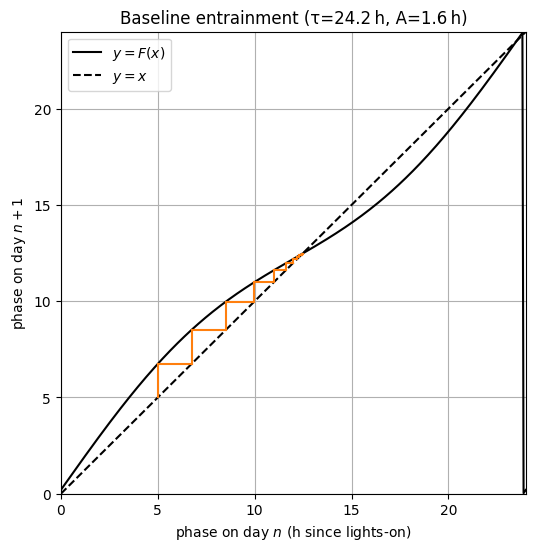

In [4]:
F_baseline = make_map(tau_int=24.2, prc_fun=lambda x: sinusoidal_prc(x, A=1.6))
cobweb(F_baseline, x0=5, days=35, title='Baseline entrainment (τ=24.2 h, A=1.6 h)')
plt.show()


#### Stability check

In [6]:
def fixed_point(F, x0=0.0, tol=1e-8, nmax=400):
    x = x0
    for _ in range(nmax):
        x_new = F(x)
        # choose shortest circular distance mod 24
        if abs(((x_new - x + 12) % 24) - 12) < tol:
            return x_new % 24
        x = x_new
    raise RuntimeError('No convergence')

x_star = fixed_point(F_baseline, 5)
# numerical derivative
eps = 1e-5
slope = (F_baseline(x_star+eps) - F_baseline(x_star-eps))/(2*eps)
print(f'Fixed point at x* = {x_star:.3f} h')
print(f"Slope F'(x*) ~ {slope:.3f}  ->  |F'| {"<" if abs(slope)<1 else ">"} 1")

Fixed point at x* = 12.479 h
Slope F'(x*) ~ 0.584  ->  |F'| < 1


## 4 Example 2 – Bright‑light therapy vs dim light

Increase light intensity ⇒ scale up the PRC amplitude.  
Below we compare **dim indoor light** (A = 0.8 h) with a **bright‑light box** (A = 2.5 h) for the same long intrinsic period (24.5 h).

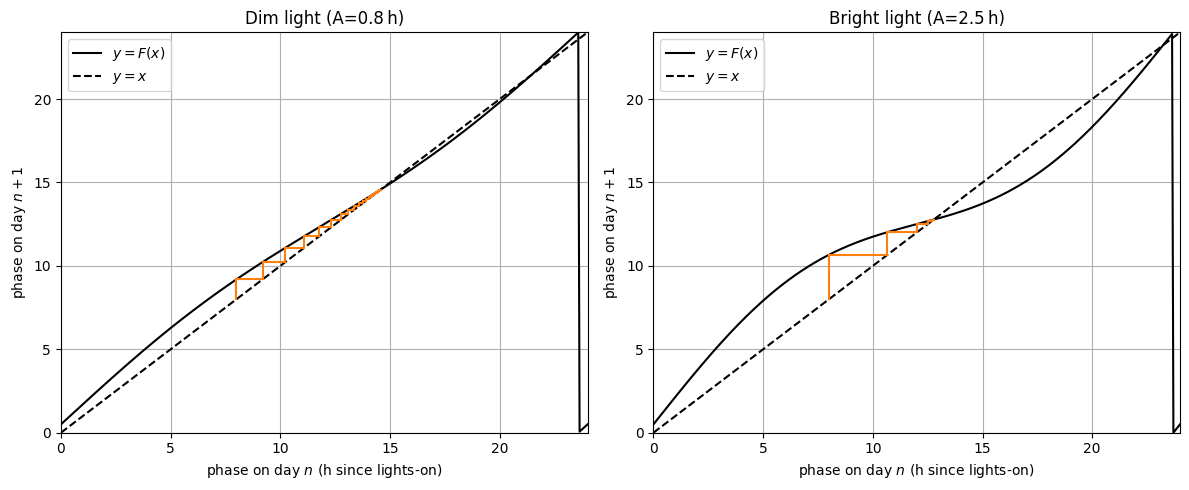

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for ax, A, ttl in zip(axes, [0.8, 2.5], ['Dim light (A=0.8 h)', 'Bright light (A=2.5 h)']):
    F = make_map(tau_int=24.5, prc_fun=lambda x, A=A: sinusoidal_prc(x, A=A))
    cobweb(F, x0=8, days=45, ax=ax, title=ttl)
plt.tight_layout()
plt.show()


## 5 Example 3 – Jet‑lag re‑entrainment

Suppose the traveller is stably entrained with phase $x^*$

A **6 h eastward flight** makes local lights‑on occur earlier relative to the body—equivalent to adding 6 h to the phase.

We iterate the map from that shifted phase and plot recovery.

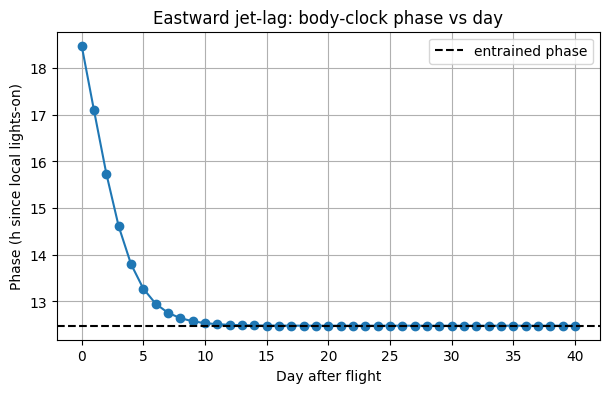

Within 0.5 h after 6 days


In [8]:
F = make_map(tau_int=24.2, prc_fun=lambda x: sinusoidal_prc(x, A=1.6))
x_star = fixed_point(F, 5)
shift = 6  # hours
x0 = (x_star + shift) % 24

days = 40
phase = [x0]
x = x0
for _ in range(days):
    x = F(x)
    phase.append(x)

plt.figure(figsize=(7,4))
plt.plot(phase, marker='o')
plt.axhline(x_star, ls='--', color='k', label='entrained phase')
plt.xlabel('Day after flight'); plt.ylabel('Phase (h since local lights‑on)')
plt.title('Eastward jet‑lag: body‑clock phase vs day')
plt.legend(); plt.grid(True); plt.show()

# Days to within 0.5 h of entrained phase
for i, ph in enumerate(phase):
    circ_err = abs(((ph - x_star + 12) % 24) - 12)
    if circ_err < 0.5:
        print(f'Within 0.5 h after {i} days')
        break


## 6 Example 4 – Seasonal photoperiod change

Longer daylight tends to **flatten** the PRC (smaller net daily shift) because light covers both advance and delay zones.

We mimic this by scaling the PRC amplitude with photoperiod length $N$ via

$$
A(N) = A_{\text{max}}\bigl[\,1 - c\,|N - 12|/12\,\bigr].
$$

A bifurcation occurs when $|F'(x^*)|$ crosses 1.


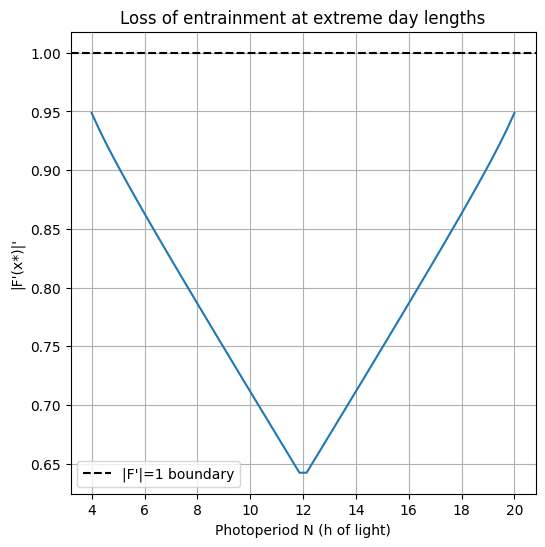

In [27]:
tau_int = 24.2
A_max, c = 1.4, 1.2
Ns = np.linspace(4, 20, 60)
abs_slope = []
for N in Ns:
    A = A_max*(1 - c*abs(N-12)/12)
    F = make_map(tau_int, prc_fun=lambda x, A=A: sinusoidal_prc(x, A=A))
    x_star = fixed_point(F, 5)
    eps = 1e-5
    s = (F(x_star+eps)-F(x_star-eps))/(2*eps)
    abs_slope.append(abs(s))

plt.figure()
plt.plot(Ns, abs_slope)
plt.axhline(1, ls='--', color='k', label="|F'|=1 boundary")
plt.xlabel('Photoperiod N (h of light)')
plt.ylabel(r"|F'(x*)|'")
plt.title('Loss of entrainment at extreme day lengths')
plt.legend(); plt.show()

## 7 Take‑aways

* **Entrainment map = cobweb diagram** for a circadian clock under a 24‑h zeitgeber.  
* Fixed point gives **phase of entrainment**; slope gives **stability & speed**.  
* Bright light increases PRC amplitude → stronger attraction.  
* Jet‑lag recovery time reads off directly from cobweb stair‑steps.  
* Seasonal photoperiod can destroy entrainment when $|F'(x^*)| > 1$


Experiment: vary `tau_int`, or PRC shape, to mimic individual differences between people.